In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import re
import sys
sys.path.append("../")

from utils.dataset import SerializationDataset
from models.generator import Seq2SeqGenerator

import tensorflow as tf 
assert int(tf.__version__[:1]) < 2.0, "해당 코드는 1.x에서만 동작합니다."
tf.logging.set_verbosity(tf.logging.ERROR)

# \[ 2. MNIST 데이터셋 - SRN(Sequence Recognition Network) \]

MNIST 데이터셋을 통해 `SRN(Sequence Recognition Network)`을 학습시켜보도록 하겠습니다. SRN은 CRNN의 구조와 Seq2Seq, 그리고 Attention Network을 합친 모델입니다.

![Imgur](https://i.imgur.com/M11craN.png)

## 1. 데이터 가져오기 

In [4]:
train_set = SerializationDataset('mnist','train',
                                 digit=(3,10),pad_range=(3,10))
validation_set = SerializationDataset('mnist','validation',
                                      digit=(3,10),pad_range=(3,10))
test_set = SerializationDataset('mnist','test',
                                digit=(3,8),pad_range=(3,10))

## 2. 데이터 Generator 가져오기

In [5]:
train_gen = Seq2SeqGenerator(train_set, 
                          batch_size=32)
valid_gen = Seq2SeqGenerator(validation_set, 
                          batch_size=100, 
                          shuffle=False)
test_gen = Seq2SeqGenerator(test_set, 
                         batch_size=500, 
                         shuffle=False)

conv2text = test_gen.convert2text

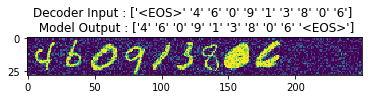

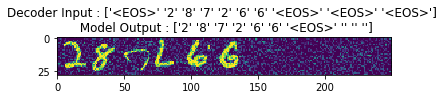

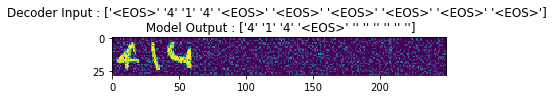

In [6]:
X,Y = train_gen[0]
for i in range(3):
    image = X['images'][i,:,:,0]
    dec_input = X['decoder_inputs'][i]
    dec_input = conv2text(dec_input)
    
    output = Y['output_seqs'][i]
    output = conv2text(output)

    plt.title(f"Decoder Input : {dec_input} \n Model Output : {output}")
    plt.imshow(image)
    plt.show()

> 모델을 학습할 때에는 Images, Decoder Input, Model Output 이렇게 총 3개의 데이터가 필요합니다. Decoder input과 Model Output은 1번의 Time Step 만큼 차이가 납니다. 

----

# 3. 모델 구성하기



In [7]:
from models.layers import ConvFeatureExtractor, Map2Sequence
from models.layers import ResidualConvFeatureExtractor
from models.layers import BLSTMEncoder, CTCDecoder

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TimeDistributed

## (1) Source Features 계산하기

![Imgur](https://i.imgur.com/nDZbuC2.png)

In [9]:
height = 28
num_classes = 10
n_conv = 16

K.clear_session()

# For Gray Scale Image & Dynamic width
inputs = Input(shape=(height, None, 1),name='images')

# n_conv == Convolution Filter의 갯수를 정하는 계수 F
conv_maps = ConvFeatureExtractor(n_conv,
                                 name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

#### C.F) `Map2Sequence`의 역할

Conv_maps의 Shape을 변경하여, Bidirectional LSTM Layer의 Input Shape 형태로 변경

In [10]:
print(f"conv_maps의 shape : {conv_maps.shape}")
print(f"feature_seqs의 shape : {feature_seqs.shape}")

conv_maps의 shape : (?, 1, ?, 128)
feature_seqs의 shape : (?, ?, 128)


## (2) Encoder State Vector($S_{encoder}$) 계산하기

![Imgur](https://i.imgur.com/kgZLw3N.png)

$$
states_{encoder} = [H_{forward} ; H_{backward}]
$$

In [11]:
n_lstm = 256
states_encoder = BLSTMEncoder(n_units=n_lstm)(feature_seqs)

In [12]:
print(f'states_encoder의 shape : {states_encoder.shape}')

states_encoder의 shape : (?, ?, 512)


> Bidirectional 이므로, Forward 방향에서의 state, Backward 방향에서의 state가 모였기 때문에 n_lstm의 2배만큼 됩니다.

### (3) Decoder Embedding 계산하기

![Imgur](https://i.imgur.com/f0jLCf5.png)

In [13]:
# For Gray Scale Image & Dynamic width
n_embed = 256
decoder_inputs = Input(shape=(None,),name='decoder_inputs')

embedding_layer = Embedding(num_classes+1, n_embed)
embeded_decoder_inputs = embedding_layer(decoder_inputs)

> n_embed 의 크기는 임의로 정할 수 있습니다. 이번에는 256으로 하였습니다.

### (4) Decoder State Vector($S_{decoder}$) 계산하기

![Imgur](https://i.imgur.com/yArrBKh.png)

우리는 초기 state를 넣는 인자를 따로 만들었습니다.<br>
이후에 inference Logic을 짤 때, Decoder Logic에서 필요하므로 추가하였습니다.

In [14]:
decoder_state = Input(shape=(n_lstm*2,), name='decoder_state')
gru_layer = GRU(n_lstm*2, 
                name='decoder_gru', 
                return_sequences=True)

states_decoder = gru_layer(embeded_decoder_inputs,
                           initial_state=decoder_state)

In [15]:
states_decoder

<tf.Tensor 'decoder_gru/transpose_1:0' shape=(?, ?, 512) dtype=float32>

## (5) Context Vector($C$) 계산하기

![Imgur](https://i.imgur.com/cWG0dxO.png)

$$
\mbox{(Dot-Attention Score Function) :} \\
\omega_{i,j} = score(s_t,h_i) = s_t^{T}h_i
$$

위와 같은 방식으로 Score을 계산합니다.


![Imgur](https://i.imgur.com/ISYwg4N.png)



$$
\mbox{(Score Normalization) :} \\
\alpha_{i,j} = \frac{exp(w_{i,j})}{\sum_{t=1}^{m}exp(w_{i,t})}
$$

위와 같은 방식으로 Attention Weght($\alpha_{i,j}$)을 계산합니다.

![Imgur](https://i.imgur.com/gQsgFve.png)

 Attention Weight는 각 Decoder의 Time Step 별로, 어떤 Encoder의 State에 대해 가중치를 곱해줄지를 결정하게 됩니다. 그렇게 곱해준 후 더해준 것이, 문맥에 대한 정보인 Context Vector($C_j$)입니다.

In [16]:
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Layer

In [17]:
class DotAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, inputs, **kwargs):
        states_encoder = inputs[0]
        states_decoder = inputs[1]
        
        # (1) Calculate Score
        expanded_states_encoder = states_encoder[:,None,...] 
        # >>> (batch size, 1, length of encoder sequence, num hidden)
        expanded_states_decoder = states_decoder[...,None,:] 
        # >>> (batch size, length of decoder sequence, 1, num hidden)            
        score = K.sum(expanded_states_encoder * expanded_states_decoder,
                          axis=-1)
        # >>> (batch size, length of decoder input, length of encoder input)
        
        # (2) Normalize score
        attention = Softmax(axis=-1, name='attention')(score)
        
        # (3) Calculate Context Vector
        context = K.sum(expanded_states_encoder * attention[...,None], axis=2)
        # >>> (batch size, length of decoder input, num hidden)
        
        return context, attention

In [18]:
dotattend = DotAttention()

context, attention = dotattend([states_encoder, states_decoder])

## (6) prediction with Softmax

![Imgur](https://i.imgur.com/nXJQrCg.png)

In [19]:
n_clf = 256

clf1_layer = Dense(n_clf, activation='relu')
clf2_layer = Dense(num_classes+1, 
                   activation='softmax',
                   name='output_seqs')

concat_output = concatenate([context, states_decoder],
                            name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

각 Time Step 별로 동일한 Classifier를 적용해주어야 합니다. 이렇게 하기 위해서 Time Step 별로 Layer을 적용해주는 `TimeDistributed`를 이용하였습니다.

### (7) 모델의 Layer 구성하기

In [21]:
K.clear_session()

height = 28
num_classes = 10
n_conv = 16 # the number of Convolution filter
n_state = 256 # the number of BLSM units
n_embed = 256 # the size of embedding vector
n_clf = 256 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ConvFeatureExtractor(n_conv,
                                 name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
states_encoder = Dense(n_state, activation='tanh')(feature_seqs)
#states_encoder = BLSTMEncoder(n_units=n_lstm)(feature_seqs)    

# Embedding Layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
embedding_layer = Embedding(num_classes+1, n_embed)
embedding_target = embedding_layer(decoder_inputs)

# Text Decoder
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(embedding_target,
                           initial_state=decoder_state_inputs)

# Attention Layer
dotattend = DotAttention()
context, attention = dotattend([states_encoder, states_decoder])

# Classifier Layer
clf1_layer = Dense(n_clf, activation='relu')
clf2_layer = Dense(num_classes+1, activation='softmax',name='output_seqs')

concat_output = concatenate([context, states_decoder], name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

## (8) 추론 모델과 학습 모델 구성하기

In [22]:
# For training
trainer = Model([inputs, 
                 decoder_inputs,
                 decoder_state_inputs], 
                predictions, name='trainer')

# For Inference
# - (1) Encoder
encoder = Model(inputs, states_encoder, 
                name='encoder')

# - (2) Decoder
states_encoder_input = Input((None,n_state), 
                             name='states_encoder_input')

context, attention = dotattend([states_encoder_input, states_decoder])
concat_output = concatenate([context, states_decoder], axis=-1, 
                            name='concat_output')
fc_outputs = TimeDistributed(clf1_layer)(concat_output)
predictions = TimeDistributed(clf2_layer, name='output_seqs')(fc_outputs)

decoder = Model([states_encoder_input, decoder_inputs, decoder_state_inputs], 
                [states_decoder, predictions], name='decoder')

In [23]:
trainer.summary()

Model: "trainer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, None, 1) 0                                            
__________________________________________________________________________________________________
feature_extractor (ConvFeatureE (None, 1, None, 128) 348096      images[0][0]                     
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
map_to_sequence (Map2Sequence)  (None, None, 128)    0           feature_extractor[0][0]          
____________________________________________________________________________________________

## (9) 학습 모델 Compile하기

In [24]:
from models.optimizer import AdamW
from models.losses import masking_sparse_categorical_crossentropy

In [25]:
y_true = tf.placeholder(shape=(None, None), dtype=tf.int32)

trainer.compile(AdamW(lr=1e-3),
                loss={"output_seqs":masking_sparse_categorical_crossentropy(-1)},
                target_tensors=[y_true])

## (10) 모델 학습하기

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [27]:
callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=5, 
    min_lr=1e-6, verbose=1)
callbacks.append(rlrop)

epochs = 50

In [28]:
train_gen = Seq2SeqGenerator(train_set, 
                          batch_size=32,
                          state_size=256)
valid_gen = Seq2SeqGenerator(validation_set, 
                             batch_size=100,
                             shuffle=False,
                             state_size=256)                            
test_gen = Seq2SeqGenerator(test_set, 
                            batch_size=500, 
                            shuffle=False,
                            state_size=256)                                                        

In [ ]:
hist = trainer.fit_generator(train_gen,
                             epochs=epochs,
                             validation_data=valid_gen,
                             callbacks=callbacks)

## (11) 모델 평가하기

In [ ]:
EOS_TOKEN = 10

In [ ]:
X,_ = test_gen[0]

# Target image 
target_images = X['images'][:10]

# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

In [ ]:
# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, 512))

In [ ]:
result = prev_inputs.copy()
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = np.argmax(predictions_,axis=-1)
    
    if np.all(prev_inputs == EOS_TOKEN):
        break
    result = np.concatenate([result,prev_inputs],axis=-1)
result = result[:,1:].squeeze()

In [ ]:
for image, seq in zip(target_images,result):
    plt.title(seq)
    plt.imshow(image[:,:,0])
    plt.show()


Reference : [Attention based Seq2Seq in Keras](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html)